# Hypothetical Document Embedding (HyDE) RAG

### HyDE 작동 원리

**1. 쿼리 입력:**
예: “GDPR에서 데이터 삭제 권리는 어떻게 적용되나요?”

**2. 가상 문서 생성 (Hypothetical Answer):**
LLM을 사용해 해당 쿼리에 대한 잠정적이고 요약된 응답 문서를 먼저 생성한다.

예:
> 데이터 삭제 권리는 GDPR 제17조에 규정되어 있으며, 사용자는 특정 조건 하에 자신의 개인정보 삭제를 요청할 수 있습니다. 이는 데이터 보관 목적이 끝났거나, 동의를 철회한 경우 등에 해당합니다.
프롬프트 예시:
"다음 질문에 대한 가상의 응답을 3~5문장으로 작성하세요."

**3. 가상 문서 임베딩:**
생성된 문서를 벡터 임베딩하여 검색 쿼리로 사용한다.
짧은 쿼리 대신 풍부한 의미 기반 문서 임베딩으로 검색 정확도를 향상한다.

**4. 유사 문서 검색:**
생성된 벡터를 기반으로 Vector DB에서 실제 문서 청크를 검색한다.
이때 유사도는 훨씬 정밀하게 작동한다.

**5. 응답 생성:**
검색된 실제 문서를 기반으로 최종 응답을 생성한다.
생성 결과는 LLM의 해석력이 강화된 상태에서 실행된다.


### HyDE 예시

- 질문: “개인정보 보유 기간은 얼마나 되나요?”

- 기존 RAG:

> 보유 기간이라는 키워드 중심 유사도 → "데이터 보존 정책" 언급 문서만 검색된다.

- HyDE:

> 생성된 가상 응답:
“개인정보는 수집 목적이 달성된 후 지체 없이 파기되며, 단 법령에 의해 일정 기간 보관이 요구될 수 있습니다.”
→ 실제 문서 내 유사 내용 포함된 블록을 정확히 검색한다.


## Setting Up the Environment

In [1]:
import numpy as np
import json
import fitz
import re
import matplotlib.pyplot as plt

In [2]:
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

## Document Processing Functions

In [3]:
def extract_text_from_pdf(pdf_path):
    """
    PDF 파일에서 페이지별로 텍스트와 메타데이터를 추출합니다.

    Args:
        pdf_path (str): PDF 파일 경로

    Returns:
        List[Dict]: 텍스트와 메타데이터를 포함한 페이지 목록
    """
    print(f"{pdf_path}에서 텍스트를 추출하는 중...")  # 처리 중인 PDF 경로 출력
    pdf = fitz.open(pdf_path)  # PyMuPDF를 사용하여 PDF 열기
    pages = []  # 추출된 페이지 데이터를 저장할 리스트 초기화

    # 각 페이지를 순회하며 텍스트 추출
    for page_num in range(len(pdf)):
        page = pdf[page_num]  # 현재 페이지 객체 가져오기
        text = page.get_text()  # 텍스트 추출

        # 텍스트가 50자 이하인 페이지는 건너뛰기
        if len(text.strip()) > 50:
            # 텍스트와 메타데이터를 포함하여 리스트에 추가
            pages.append({
                "text": text,
                "metadata": {
                    "source": pdf_path,       # 원본 파일 경로
                    "page": page_num + 1      # 페이지 번호 (1부터 시작)
                }
            })

    print(f"내용이 있는 페이지 {len(pages)}개를 추출했습니다.")  # 추출된 페이지 수 출력
    return pages  # 텍스트와 메타데이터를 포함한 페이지 리스트 반환

In [4]:
def chunk_text(text, chunk_size=1000, overlap=200):
    """
    텍스트를 일정 길이의 중첩 청크로 분할합니다.

    Args:
        text (str): 분할할 입력 텍스트
        chunk_size (int): 각 청크의 길이 (문자 수)
        overlap (int): 청크 간 중첩 길이 (문자 수)

    Returns:
        List[Dict]: 메타데이터를 포함한 청크 목록
    """
    chunks = []  # 생성된 청크들을 저장할 리스트 초기화

    # (chunk_size - overlap)만큼 건너뛰며 청크를 생성
    for i in range(0, len(text), chunk_size - overlap):
        chunk_text = text[i:i + chunk_size]  # 현재 구간의 텍스트 추출
        if chunk_text:  # 빈 청크는 건너뜀
            chunks.append({
                "text": chunk_text,  # 청크 텍스트
                "metadata": {
                    "start_pos": i,  # 원본 텍스트에서의 시작 위치
                    "end_pos": i + len(chunk_text)  # 종료 위치
                }
            })

    print(f"총 {len(chunks)}개의 텍스트 청크가 생성되었습니다.")  # 생성된 청크 수 출력
    return chunks  # 청크 리스트 반환

## Simple Vector Store Implementation

In [5]:
class SimpleVectorStore:
    """
    NumPy를 사용한 간단한 벡터 저장소 구현 클래스입니다.
    """
    def __init__(self):
        self.vectors = []    # 임베딩 벡터들을 저장하는 리스트
        self.texts = []      # 해당 벡터에 대응되는 텍스트 콘텐츠
        self.metadata = []   # 텍스트에 대한 메타데이터
    
    def add_item(self, text, embedding, metadata=None):
        """
        벡터 저장소에 항목을 추가합니다.
        
        Args:
            text (str): 텍스트 콘텐츠
            embedding (List[float]): 텍스트에 대한 임베딩 벡터
            metadata (Dict, optional): 추가 메타데이터 (선택사항)
        """
        self.vectors.append(np.array(embedding))         # 임베딩 벡터를 NumPy 배열로 저장
        self.texts.append(text)                          # 텍스트 저장
        self.metadata.append(metadata or {})             # 메타데이터 저장 (없으면 빈 딕셔너리 사용)
    
    def similarity_search(self, query_embedding, k=5, filter_func=None):
        """
        쿼리 임베딩과 가장 유사한 항목들을 검색합니다.
        
        Args:
            query_embedding (List[float]): 쿼리 임베딩 벡터
            k (int): 반환할 결과 개수
            filter_func (callable, optional): 메타데이터 기반 필터링 함수 (선택사항)
        
        Returns:
            List[Dict]: 유사도가 높은 상위 k개의 항목 리스트
        """
        if not self.vectors:
            return []  # 저장된 벡터가 없으면 빈 리스트 반환
        
        # 쿼리 벡터를 NumPy 배열로 변환
        query_vector = np.array(query_embedding)
        
        # 코사인 유사도를 기반으로 유사도 계산
        similarities = []
        for i, vector in enumerate(self.vectors):
            # 필터 함수가 정의되어 있고, 조건에 맞지 않으면 건너뜀
            if filter_func and not filter_func(self.metadata[i]):
                continue
            
            # 코사인 유사도 계산
            similarity = np.dot(query_vector, vector) / (np.linalg.norm(query_vector) * np.linalg.norm(vector))
            similarities.append((i, similarity))  # 인덱스와 유사도 저장
        
        # 유사도 기준으로 내림차순 정렬
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        # 상위 k개의 결과 반환
        results = []
        for i in range(min(k, len(similarities))):
            idx, score = similarities[i]
            results.append({
                "text": self.texts[idx],                  # 해당 텍스트
                "metadata": self.metadata[idx],           # 해당 메타데이터
                "similarity": float(score)                # 유사도 점수
            })
        
        return results  # 결과 리스트 반환

## Creating Embeddings

In [6]:
def create_embeddings(texts, model="text-embedding-3-small"):
    """
    주어진 텍스트 목록에 대해 임베딩 벡터를 생성합니다.

    Args:
        texts (List[str]): 임베딩을 생성할 입력 텍스트 목록
        model (str): 사용할 임베딩 모델 이름

    Returns:
        List[List[float]]: 생성된 임베딩 벡터 리스트
    """
    # 빈 입력 처리: 텍스트가 없으면 빈 리스트 반환
    if not texts:
        return []
        
    # API 호출 제한을 고려하여 배치 단위로 처리
    batch_size = 100
    all_embeddings = []  # 전체 임베딩 결과 저장 리스트
    
    # 입력 텍스트를 배치 단위로 나누어 처리
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]  # 현재 배치 추출
        
        # 현재 배치에 대해 임베딩 생성 요청
        response = client.embeddings.create(
            model=model,
            input=batch
        )
        
        # 응답에서 임베딩 벡터만 추출
        batch_embeddings = [item.embedding for item in response.data]
        all_embeddings.extend(batch_embeddings)  # 전체 결과에 추가
    
    return all_embeddings  # 전체 임베딩 벡터 반환

## Document Processing Pipeline

In [7]:
def process_document(pdf_path, chunk_size=1000, chunk_overlap=200):
    """
    RAG 처리를 위한 문서 전처리 함수입니다.

    Args:
        pdf_path (str): PDF 파일 경로
        chunk_size (int): 각 청크의 문자 수
        chunk_overlap (int): 청크 간 중첩 문자 수

    Returns:
        SimpleVectorStore: 문서 청크가 저장된 벡터 저장소 객체
    """
    # PDF에서 텍스트 추출
    pages = extract_text_from_pdf(pdf_path)

    # 각 페이지를 처리하여 청크 생성
    all_chunks = []
    for page in pages:
        # 텍스트만 추출하여 청크 분할 함수에 전달
        page_chunks = chunk_text(page["text"], chunk_size, chunk_overlap)
        
        # 각 청크에 페이지 메타데이터 추가
        for chunk in page_chunks:
            chunk["metadata"].update(page["metadata"])  # 예: page 번호, source 파일 등
        
        all_chunks.extend(page_chunks)  # 전체 청크 리스트에 추가

    # 텍스트 청크에 대한 임베딩 생성
    print("청크 임베딩 생성 중...")
    chunk_texts = [chunk["text"] for chunk in all_chunks]
    chunk_embeddings = create_embeddings(chunk_texts)

    # 벡터 저장소 생성 및 청크 추가
    vector_store = SimpleVectorStore()
    for i, chunk in enumerate(all_chunks):
        vector_store.add_item(
            text=chunk["text"],
            embedding=chunk_embeddings[i],
            metadata=chunk["metadata"]
        )

    print(f"총 {len(all_chunks)}개의 청크로 벡터 저장소가 생성되었습니다.")
    return vector_store

## Hypothetical Document Generation

In [8]:
def generate_hypothetical_document(query, desired_length=1000):
    """
    주어진 질문에 대한 가상의 문서를 생성합니다.

    Args:
        query (str): 사용자 질문
        desired_length (int): 생성할 문서의 목표 길이 (문자 수 기준)

    Returns:
        str: 생성된 가상의 문서 콘텐츠
    """
    # 문서 생성 방식을 안내하는 시스템 프롬프트 설정
    system_prompt = f"""당신은 전문 문서 작성자입니다. 
    아래의 질문에 대해 직접적인 답변이 될 수 있는 상세한 문서를 작성하세요.
    이 문서는 약 {desired_length}자 분량이어야 하며, 주제에 대해 심층적이고 정보성 있는 설명을 포함해야 합니다.
    공식적인 출처에서 작성된 것처럼 구체적인 사실, 예시, 개념 설명 등을 포함해 주세요.
    "이것은 가상의 문서입니다"라는 언급 없이, 실제 문서처럼 자연스럽게 작성하세요."""

    # 사용자 프롬프트에 질문 포함
    user_prompt = f"질문: {query}\n\n이 질문에 대한 문서를 작성해 주세요:"

    # OpenAI API 호출을 통해 문서 생성 요청
    response = client.chat.completions.create(
        model="gpt-4o-mini",  # 사용할 모델 지정
        messages=[
            {"role": "system", "content": system_prompt},  # 시스템 역할 지시
            {"role": "user", "content": user_prompt}  # 사용자 입력 (질문 포함)
        ],
        temperature=0.1  # 낮은 온도로 안정적인 문서 생성 유도
    )

    # 생성된 문서 텍스트 반환
    return response.choices[0].message.content


## Complete HyDE RAG Implementation

In [9]:
def hyde_rag(query, vector_store, k=5, should_generate_response=True):
    """
    HyDE (가상 문서 임베딩 기반 검색) 방식으로 RAG를 수행합니다.

    Args:
        query (str): 사용자 질문
        vector_store (SimpleVectorStore): 문서 청크가 저장된 벡터 저장소
        k (int): 검색할 청크 개수
        should_generate_response (bool): 최종 응답을 생성할지 여부

    Returns:
        Dict: 가상 문서, 검색된 청크, (선택 시) 응답을 포함한 결과
    """
    print(f"\n=== HyDE 방식으로 쿼리 처리 중: {query} ===\n")
    
    # 1단계: 질문에 대한 가상의 문서 생성
    print("가상 문서 생성 중...")
    hypothetical_doc = generate_hypothetical_document(query)
    print(f"생성된 가상 문서 길이: {len(hypothetical_doc)}자")
    
    # 2단계: 생성된 가상 문서에 대한 임베딩 생성
    print("가상 문서 임베딩 생성 중...")
    hypothetical_embedding = create_embeddings([hypothetical_doc])[0]
    
    # 3단계: 가상 문서 임베딩을 기반으로 유사한 문서 청크 검색
    print(f"가장 유사한 청크 {k}개 검색 중...")
    retrieved_chunks = vector_store.similarity_search(hypothetical_embedding, k=k)
    
    # 결과 딕셔너리 구성
    results = {
        "query": query,
        "hypothetical_document": hypothetical_doc,
        "retrieved_chunks": retrieved_chunks
    }
    
    # 4단계: 최종 응답 생성 여부에 따라 처리
    if should_generate_response:
        print("최종 응답 생성 중...")
        response = generate_response(query, retrieved_chunks)
        results["response"] = response
    
    return results

## Standard (Direct) RAG Implementation for Comparison

In [10]:
def standard_rag(query, vector_store, k=5, should_generate_response=True):
    """
    쿼리 임베딩을 직접 사용하여 RAG를 수행하는 표준 방식입니다.

    Args:
        query (str): 사용자 질문
        vector_store (SimpleVectorStore): 문서 청크가 저장된 벡터 저장소
        k (int): 검색할 상위 청크 개수
        should_generate_response (bool): 최종 응답을 생성할지 여부

    Returns:
        Dict: 검색된 청크 및 (선택적으로) 생성된 응답을 포함한 결과
    """
    print(f"\n***Standard RAG 방식으로 쿼리 처리 중: {query}***\n")
    
    # 1단계: 쿼리 임베딩 생성
    print("쿼리 임베딩 생성 중...")
    query_embedding = create_embeddings([query])[0]
    
    # 2단계: 유사한 문서 청크 검색
    print(f"가장 유사한 청크 {k}개 검색 중...")
    retrieved_chunks = vector_store.similarity_search(query_embedding, k=k)
    
    # 결과 딕셔너리 구성
    results = {
        "query": query,
        "retrieved_chunks": retrieved_chunks
    }
    
    # 3단계: 응답 생성 여부에 따라 처리
    if should_generate_response:
        print("최종 응답 생성 중...")
        response = generate_response(query, retrieved_chunks)
        results["response"] = response
        
    return results

## Response Generation

In [11]:
def generate_response(query, relevant_chunks):
    """
    질문과 관련된 문서 청크를 기반으로 최종 응답을 생성합니다.

    Args:
        query (str): 사용자 질문
        relevant_chunks (List[Dict]): 검색된 관련 문서 청크 목록

    Returns:
        str: 생성된 응답 텍스트
    """
    # 검색된 청크들의 텍스트를 이어붙여 문맥(context) 생성
    context = "\n\n".join([chunk["text"] for chunk in relevant_chunks])

    # OpenAI API를 통해 응답 생성 요청
    response = client.chat.completions.create(
        model="gpt-4o-mini",  # 사용할 LLM 모델 지정
        messages=[
            {
                "role": "system",
                "content": "당신은 유용한 AI 어시스턴트입니다. 제공된 문맥을 기반으로 사용자의 질문에 답변하세요."
            },
            {
                "role": "user",
                "content": f"문맥:\n{context}\n\n질문: {query}"
            }
        ],
        temperature=0.5,   # 적절한 창의성과 안정성을 위한 온도 설정
        max_tokens=500     # 생성 응답의 최대 토큰 수 제한
    )

    # 응답 결과 반환
    return response.choices[0].message.content

## Evaluation Functions

In [12]:
def compare_approaches(query, vector_store, reference_answer=None):
    """
    주어진 쿼리에 대해 HyDE 방식과 표준 RAG 방식을 비교합니다.

    Args:
        query (str): 사용자 질문
        vector_store (SimpleVectorStore): 문서 청크가 저장된 벡터 저장소
        reference_answer (str, optional): 기준 정답 (평가용, 선택 사항)

    Returns:
        Dict: 두 방식의 응답 및 비교 분석 결과
    """
    # 1단계: HyDE 기반 RAG 실행
    hyde_result = hyde_rag(query, vector_store)
    hyde_response = hyde_result["response"]

    # 2단계: 표준 RAG 실행
    standard_result = standard_rag(query, vector_store)
    standard_response = standard_result["response"]

    # 3단계: 두 응답 비교 분석
    comparison = compare_responses(
        query, 
        hyde_response, 
        standard_response, 
        reference_answer
    )

    # 결과 반환
    return {
        "query": query,  # 원본 질문
        "hyde_response": hyde_response,  # HyDE 방식으로 생성된 응답
        "hyde_hypothetical_doc": hyde_result["hypothetical_document"],  # HyDE 방식의 가상 문서
        "standard_response": standard_response,  # 표준 RAG 응답
        "reference_answer": reference_answer,  # 기준 정답 (선택)
        "comparison": comparison  # LLM 기반 비교 분석 결과
    }

In [13]:
def compare_responses(query, hyde_response, standard_response, reference=None):
    """
    HyDE 방식과 표준 RAG 방식의 응답을 비교 분석합니다.

    Args:
        query (str): 사용자 질문
        hyde_response (str): HyDE 방식 RAG의 응답
        standard_response (str): 표준 RAG의 응답
        reference (str, optional): 기준 정답 (선택 사항)

    Returns:
        str: 두 응답에 대한 비교 분석 결과
    """
    # 평가 모델에게 역할과 평가 기준을 전달하는 시스템 프롬프트
    system_prompt = """당신은 정보 검색 시스템 평가 전문가입니다.
    동일한 질문에 대해 생성된 두 가지 응답을 비교해 주세요. 
    하나는 HyDE (가상 문서 임베딩 기반), 다른 하나는 표준 RAG (직접 쿼리 임베딩 기반)입니다.

    다음 항목을 기준으로 평가해 주세요:
    1. 정확성: 어떤 응답이 더 사실에 기반한 정보를 제공하는가?
    2. 관련성: 어떤 응답이 질문을 더 잘 충족시키는가?
    3. 완전성: 어떤 응답이 주제를 더 포괄적으로 다루는가?
    4. 명확성: 어떤 응답이 더 잘 구성되어 있고 이해하기 쉬운가?

    각 접근 방식의 장단점을 구체적으로 설명해 주세요."""

    # 사용자 프롬프트에 질문 및 두 응답 추가
    user_prompt = f"""질문: {query}

    [HyDE RAG 응답]
    {hyde_response}

    [표준 RAG 응답]
    {standard_response}"""

    # 기준 정답이 존재하면 추가
    if reference:
        user_prompt += f"""

    [기준 정답]
    {reference}"""

    # 마지막 요청 문구 추가
    user_prompt += """

    이 두 응답 중 어떤 방식이 더 우수했는지, 그 이유를 명확히 분석해 주세요."""

    # OpenAI API 호출하여 비교 분석 요청
    response = client.chat.completions.create(
        model="gpt-4o-mini",  # 평가 모델
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0  # 일관된 판단을 위한 낮은 온도
    )

    # LLM이 생성한 비교 분석 결과 반환
    return response.choices[0].message.content

In [14]:
def run_evaluation(pdf_path, test_queries, reference_answers=None, chunk_size=1000, chunk_overlap=200):
    """
    여러 테스트 질문을 기반으로 HyDE와 표준 RAG 방식을 평가합니다.

    Args:
        pdf_path (str): 평가할 PDF 문서 경로
        test_queries (List[str]): 테스트 질문 목록
        reference_answers (List[str], optional): 각 질문에 대한 기준 정답 목록 (선택 사항)
        chunk_size (int): 각 청크의 문자 수
        chunk_overlap (int): 청크 간 중첩 문자 수

    Returns:
        Dict: 각 쿼리의 평가 결과 및 전체 분석 내용
    """
    # 문서를 처리하여 벡터 저장소 생성
    vector_store = process_document(pdf_path, chunk_size, chunk_overlap)

    results = []  # 쿼리별 결과 저장 리스트

    for i, query in enumerate(test_queries):
        print(f"\n\n===== 쿼리 평가 {i+1}/{len(test_queries)} =====")
        print(f"질문: {query}")

        # 기준 정답이 있으면 함께 사용
        reference = None
        if reference_answers and i < len(reference_answers):
            reference = reference_answers[i]

        # HyDE vs 표준 RAG 방식 비교
        result = compare_approaches(query, vector_store, reference)
        results.append(result)

    # 전체 평가에 대한 종합 분석 생성
    overall_analysis = generate_overall_analysis(results)

    return {
        "results": results,  # 개별 쿼리 평가 결과
        "overall_analysis": overall_analysis  # 전체 성능 분석
    }

In [15]:
def generate_overall_analysis(results):
    """
    다수의 쿼리 평가 결과를 기반으로 HyDE RAG과 표준 RAG에 대한 전체 분석을 생성합니다.

    Args:
        results (List[Dict]): 개별 쿼리 평가 결과 목록

    Returns:
        str: 두 접근 방식의 성능 비교에 대한 종합 분석 결과
    """
    # LLM에게 평가 기준을 명확히 전달하는 시스템 프롬프트
    system_prompt = """당신은 정보 검색 시스템 평가 전문가입니다.
    여러 개의 테스트 쿼리를 기반으로, HyDE RAG (가상 문서 임베딩 기반)과 
    표준 RAG (직접 쿼리 임베딩 기반)의 전반적인 성능을 비교 분석하세요.

    다음 항목에 초점을 맞춰 작성하세요:
    1. HyDE가 더 나은 성능을 보이는 상황과 그 이유
    2. 표준 RAG이 더 나은 성능을 보이는 상황과 그 이유
    3. HyDE 방식이 특히 효과적인 질문 유형
    4. 각 접근 방식의 전반적인 강점과 한계
    5. 어떤 상황에서 각각을 사용하는 것이 적절한지에 대한 추천"""

    # 각 쿼리별 비교 요약을 텍스트로 구성
    evaluations_summary = ""
    for i, result in enumerate(results):
        evaluations_summary += f"질문 {i+1}: {result['query']}\n"
        evaluations_summary += f"비교 요약: {result['comparison'][:200]}...\n\n"

    # 사용자 프롬프트 구성
    user_prompt = f"""아래는 총 {len(results)}개의 쿼리에 대해 HyDE와 표준 RAG을 비교한 평가 요약입니다.
    이 내용을 바탕으로 두 접근 방식에 대한 전반적인 분석을 작성해 주세요:

    {evaluations_summary}

    HyDE가 표준 RAG보다 어떤 면에서 강점을 가지는지, 어떤 경우에 더 적합한지 등을 중심으로
    상대적인 강점과 약점, 그리고 활용 전략에 대해 포괄적으로 분석해 주세요."""

    # OpenAI API 호출을 통해 분석 요청
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0  # 일관된 평가를 위한 낮은 온도
    )

    # 생성된 분석 결과 반환
    return response.choices[0].message.content

## Visualization Functions

In [16]:
def visualize_results(query, hyde_result, standard_result):
    """
    HyDE와 표준 RAG 방식의 결과를 시각적으로 비교합니다.

    Args:
        query (str): 사용자 질문
        hyde_result (Dict): HyDE RAG의 실행 결과
        standard_result (Dict): 표준 RAG의 실행 결과
    """
    # 3개의 서브플롯으로 구성된 시각화 도표 생성
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # [1] 첫 번째 플롯: 쿼리 표시
    axs[0].text(0.5, 0.5, f"질문:\n\n{query}", 
                horizontalalignment='center', verticalalignment='center',
                fontsize=12, wrap=True)
    axs[0].axis('off')  # 축 숨김

    # [2] 두 번째 플롯: HyDE가 생성한 가상 문서 표시
    hypothetical_doc = hyde_result["hypothetical_document"]
    shortened_doc = hypothetical_doc[:500] + "..." if len(hypothetical_doc) > 500 else hypothetical_doc

    axs[1].text(0.5, 0.5, f"HyDE 생성 문서:\n\n{shortened_doc}", 
                horizontalalignment='center', verticalalignment='center',
                fontsize=10, wrap=True)
    axs[1].axis('off')  # 축 숨김

    # [3] 세 번째 플롯: 두 방식에서 검색된 청크 비교
    hyde_chunks = [chunk["text"][:100] + "..." for chunk in hyde_result["retrieved_chunks"]]
    std_chunks = [chunk["text"][:100] + "..." for chunk in standard_result["retrieved_chunks"]]

    # 비교 텍스트 조립
    comparison_text = "HyDE 방식으로 검색된 청크:\n\n"
    for i, chunk in enumerate(hyde_chunks):
        comparison_text += f"{i+1}. {chunk}\n\n"

    comparison_text += "\n표준 RAG 방식으로 검색된 청크:\n\n"
    for i, chunk in enumerate(std_chunks):
        comparison_text += f"{i+1}. {chunk}\n\n"

    # 비교 텍스트 시각화
    axs[2].text(0.5, 0.5, comparison_text,
                horizontalalignment='center', verticalalignment='center',
                fontsize=8, wrap=True)
    axs[2].axis('off')

    # 레이아웃 조정 후 시각화 출력
    plt.tight_layout()
    plt.show()

## Evaluation of Hypothetical Document Embedding (HyDE) vs. Standard RAG

dataset/AI_Understanding.pdf에서 텍스트를 추출하는 중...
내용이 있는 페이지 15개를 추출했습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
청크 임베딩 생성 중...
총 30개의 청크로 벡터 저장소가 생성되었습니다.

=== HyDE 방식으로 쿼리 처리 중: 인공지능 개발에서 주요 윤리적 고려사항은 무엇인가요? ===

가상 문서 생성 중...
생성된 가상 문서 길이: 1305자
가상 문서 임베딩 생성 중...
가장 유사한 청크 5개 검색 중...
최종 응답 생성 중...

***HyDE 응답 결과***
인공지능 개발에서 주요 윤리적 고려사항은 다음과 같습니다:

1. **편견과 공정성**: AI 시스템이 데이터에 존재하는 편견을 계승하고 증폭할 수 있으므로, 공정성을 보장하고 편견을 완화하는 것이 중요합니다.

2. **투명성 및 설명 가능성**: AI의 결정 과정이 이해 가능하도록 하여 사용자와 이해관계자가 AI 시스템의 작동 방식을 알 수 있도록 해야 합니다.

3. **개인정보 보호**: 사용자 데이터의 안전과 개인정보 보호를 보장하는 것이 필수적입니다.

4. **책임성**: AI 시스템의 결과에 대한 책임을 명확히 하고, 시스템이 잘못된 결정을 내렸을 때의 책임 소재를 규명해야 합니다.

5. **사용자 제어 및 대행사**: 사용자가 AI 시스템을 제어할 수

/tmp/ipykernel_3605858/2725143544.py:48: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3605858/2725143544.py:48: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3605858/2725143544.py:48: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3605858/2725143544.py:48: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3605858/2725143544.py:48: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3605858/2725143544.py:48: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3605858/2725143544.py:48: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_360585

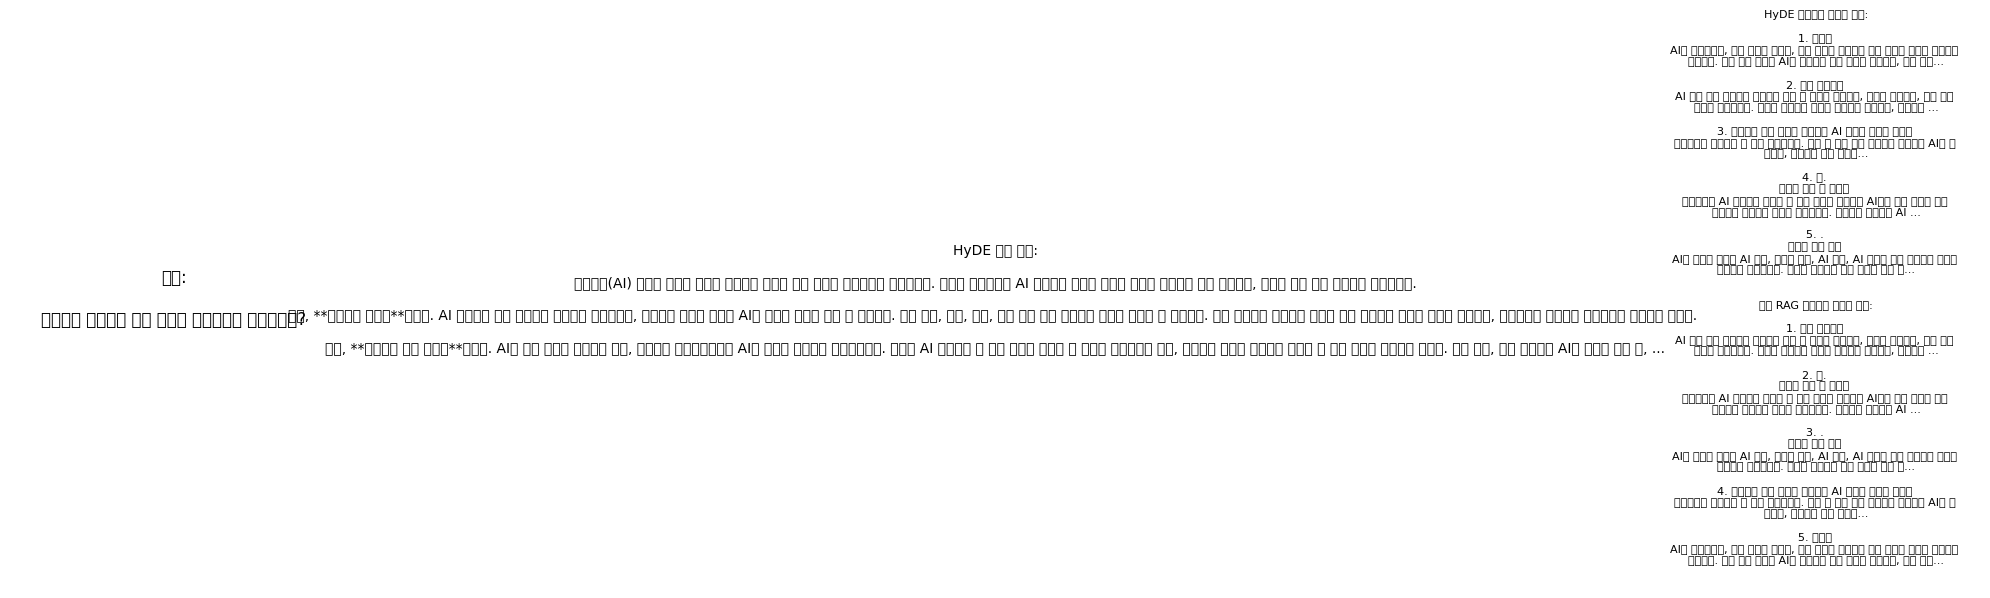

dataset/AI_Understanding.pdf에서 텍스트를 추출하는 중...
내용이 있는 페이지 15개를 추출했습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
총 2개의 텍스트 청크가 생성되었습니다.
청크 임베딩 생성 중...
총 30개의 청크로 벡터 저장소가 생성되었습니다.


===== 쿼리 평가 1/1 =====
질문: 신경망 구조는 AI 성능에 어떤 영향을 미치나요?

=== HyDE 방식으로 쿼리 처리 중: 신경망 구조는 AI 성능에 어떤 영향을 미치나요? ===

가상 문서 생성 중...
생성된 가상 문서 길이: 1330자
가상 문서 임베딩 생성 중...
가장 유사한 청크 5개 검색 중...
최종 응답 생성 중...

***Standard RAG 방식으로 쿼리 처리 중: 신경망 구조는 AI 성능에 어떤 영향을 미치나요?***

쿼리 임베딩 생성 중...
가장 유사한 청크 5개 검색 중...
최종 응답 생성 중...

***전체 평가 분석***
### HyDE RAG와 표준 RAG의 비교 분석

#### 1. HyDE RAG의 강점과 적합한 상황
- **정확성 및 깊이 있는 정보 제공**: HyDE RAG는 신경망 구조의 다양한 요소에 대해 구체적이고 체계적인 설명을 제공하여, 복잡한 주제에 대한 깊이 있는 이해를 가능하게 합니다. 이는 특히 기술적이고 전문적인 질문에 대해 더 나은 성능을 발휘합니다.
- **문서 임베

In [17]:
# AI 정보가 담긴 PDF 문서 경로
pdf_path = "../../dataset/AI_Understanding.pdf"

# 문서를 처리하고 벡터 저장소 생성
# (텍스트 추출 → 청크 분할 → 임베딩 생성까지 포함)
vector_store = process_document(pdf_path)

# 예제 1: 단일 쿼리에 대해 HyDE vs Standard RAG 비교
query = "인공지능 개발에서 주요 윤리적 고려사항은 무엇인가요?"

# HyDE RAG 실행
# → 질문에 대한 가상 문서를 생성하고, 이를 임베딩한 후 유사 문서 검색
hyde_result = hyde_rag(query, vector_store)
print("\n***HyDE 응답 결과***")
print(hyde_result["response"])

# 표준 RAG 실행
# → 질문을 직접 임베딩하여 관련 문서 검색
standard_result = standard_rag(query, vector_store)
print("\n***Standard RAG 응답 결과***")
print(standard_result["response"])

# 두 방식의 차이를 시각적으로 비교
# → 질문, HyDE 생성 문서, 검색된 청크들을 나란히 보여줌
visualize_results(query, hyde_result, standard_result)

# 예제 2: 여러 쿼리에 대해 비교 평가 실행
test_queries = [
    "신경망 구조는 AI 성능에 어떤 영향을 미치나요?"
]

# 선택적 기준 정답 (정량적 평가에 도움)
reference_answers = [
    "신경망 구조는 레이어의 깊이, 너비, 연결 방식, 활성화 함수 등에 따라 AI의 성능에 큰 영향을 미칩니다. 예를 들어 CNN, RNN, 트랜스포머 구조는 각각 이미지 인식, 시퀀스 처리, 자연어 처리에 최적화되어 있습니다."
]

# HyDE vs Standard RAG 비교 평가 실행
evaluation_results = run_evaluation(
    pdf_path=pdf_path,
    test_queries=test_queries,
    reference_answers=reference_answers
)

# 전체 쿼리에 대한 평가 요약 출력
print("\n***전체 평가 분석***")
print(evaluation_results["overall_analysis"])